# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import data_processing
import plots
import models
import experiments

# Generate synthetic data

In [ ]:
orig_data = data_processing.load_prepare_aids_dataset()

In [ ]:
_, df_syn = data_processing.generate_synthetic_data(orig_data, 40000)

In [ ]:
time, censor = data_processing.determine_censor_time(df_syn)
# we can generate extra data and use only the censored samples from a given point to get a dataset with higher censoring percentage 
df_tmp = df_syn.iloc[20001:40000, :]
df_tmp2 = df_syn.iloc[0:20001, :]
df_tmp2 = pd.concat([df_tmp2, df_tmp.loc[(df_tmp['time'] < time) & (df_tmp['censor'] == False)]])

In [ ]:
df_syn = df_tmp2
df_syn.to_excel('datasets/syn/sksurv_aids.xlsx')

# Experiment
## Load pre-saved data

In [64]:
df_syn = pd.read_excel("datasets/syn/sksurv_aids.xlsx", index_col=0)
df_syn.shape[0]

20000

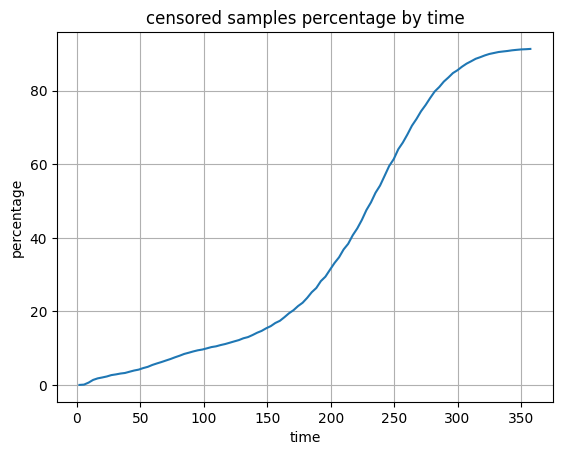

In [65]:
# plot censored percentage by time if we want to manually pick the timeframe, can also use data_processing.determine_censor_time
plots.censored_by_time_plot(df_syn)
# params dict for hyperparameter tuning
params = {'n_estimators': [80, 100, 150], 'max_depth': [8, 16, 32, 64, None], 'min_samples_split': [10, 50, 100, 200], 'max_features': ['sqrt', 'log2', 0.5, 1]}

In [72]:
# set censor time manually
censor_time = 265
print(df_syn[(df_syn['time'] < censor_time) & (df_syn['censor'] == False)].shape[0])
df_syn[(df_syn['time'] < censor_time) & (df_syn['censor'] == False)].shape[0]/df_syn.shape[0]

14096


0.7048

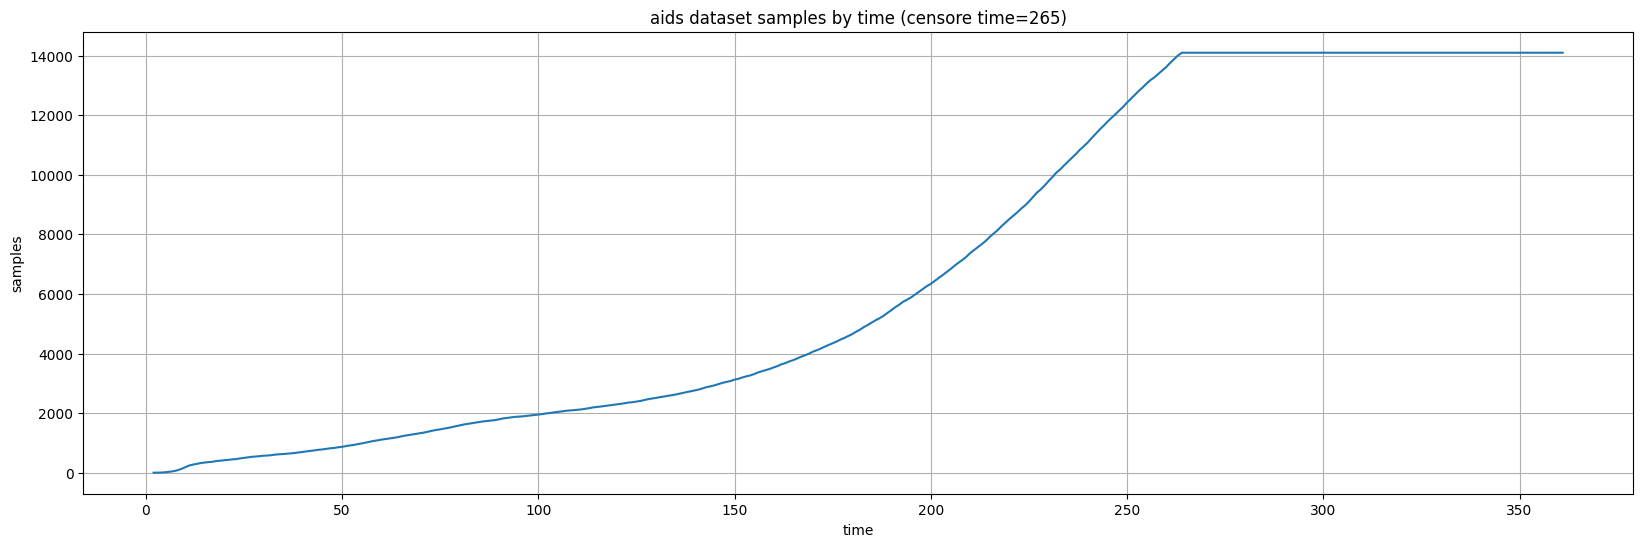

In [68]:
plots.censored_samples_by_time(df_syn, censor_time, 'aids')

## Hyperparameter tuning

In [69]:
# if we want to use default params
rsf_params = None
rfc_params = None

In [ ]:
rsf_params, best_auc_rsf = models.model_tuning_rsf(df_syn, censor_time, params, 3)

In [ ]:
datasets = data_processing.create_datasets(df_syn, censor_time)
rfc_params, best_auc_rfc = models.model_tuning(datasets['uncensored']['X_train'],datasets['uncensored']['y_train'], RandomForestClassifier(n_jobs=-1), params, verbose=3)

In [ ]:
print(f"rsf params: {rsf_params}")
print(f"rfc params: {rfc_params}")

## Train and score models

In [88]:
# if we want to manually change params
rsf_params = {'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 10, 'max_features': 'log2'}

In [89]:
rfc_params =  None

100%|██████████| 10/10 [00:41<00:00,  4.20s/it]


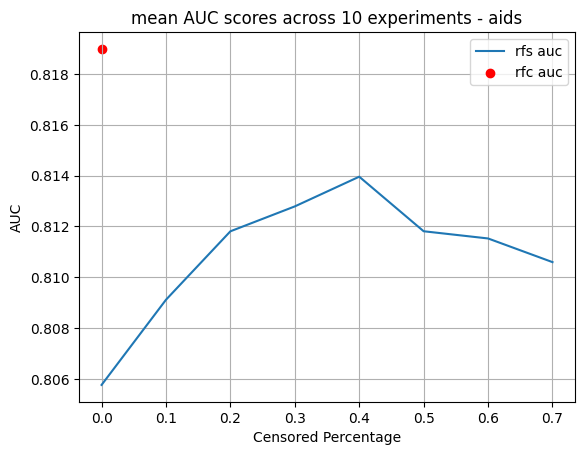

In [90]:
rfc_auc_mean = 0
rsf_auc_mean = np.zeros(8)
num_experiments = 10
n_sub_dataset = 5
df_censored = df_syn[(df_syn['time'] < censor_time) & (df_syn['censor'] == False)]
df_uncensored = df_syn[~((df_syn['time'] < censor_time) & (df_syn['censor'] == False))]
num_samples = 1300
for j in range(n_sub_dataset):
    df_exp = pd.concat([df_censored.sample(int(0.7*num_samples)), df_uncensored.sample(int(0.3*num_samples))])
    censor_vals = [x / 100.0 for x in range(0, 80, 10)]
    for i in tqdm(range(num_experiments)):
        rfc_auc, rsf_aucs, datasets = experiments.rsf_rfc(df_exp, censor_vals, censor_time, rsf_params, rfc_params)
        rfc_auc_mean += rfc_auc
        rsf_auc_mean += np.asarray(rsf_aucs)
rfc_auc_mean /= num_experiments*n_sub_dataset
rsf_auc_mean /= num_experiments*n_sub_dataset
plots.line_plot(rsf_auc_mean, rfc_auc_mean, censor_vals, num_experiments, 'aids')

In [87]:
experiments.exp_report(num_samples, 'aids', censor_vals, datasets, censor_time, rsf_params, rfc_params, {'rfc_auc_mean': rfc_auc_mean, 'rsf_auc_mean': rsf_auc_mean})